In [379]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import einops
import matplotlib
import matplotlib.pyplot as plt
import ipdb
import tqdm.notebook as tqdm
import pprint

In [380]:
SAMPLING_RATE = 0.1
DURATION = 6 * 2 * jnp.pi
T = int(DURATION / SAMPLING_RATE)

def generate_data():
    t = jnp.linspace(0, DURATION, T)    # (T,)
    frequencies = jnp.array([
        1,
        # 1.5,
        jnp.pi/2,
        # 2,
        jnp.e,
    ])  # (2,)
    omega_t = einops.rearrange(t, 't -> t ()') * frequencies  # (T, 2)
    y = jnp.sin(omega_t)  # (T, 2)
    y = y + jax.random.normal(jax.random.PRNGKey(42), y.shape) * 0.02   # noise
    return y

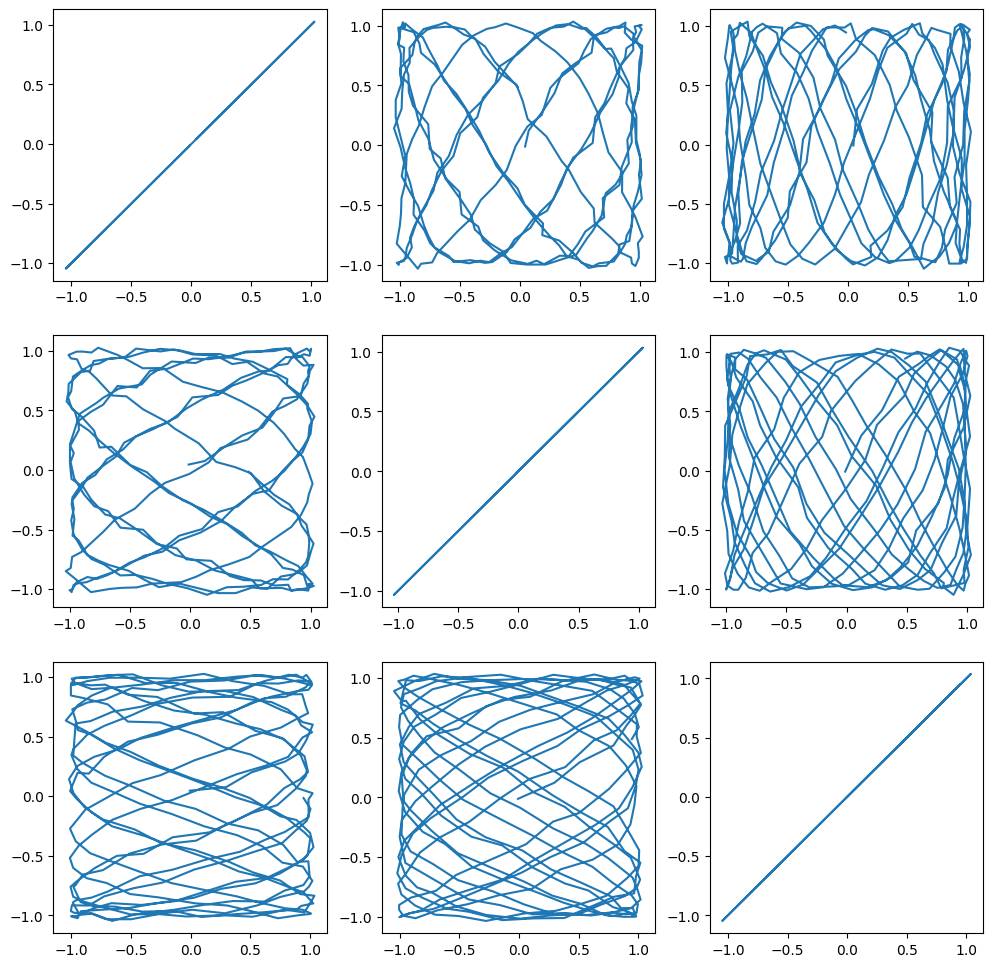

In [381]:
y = generate_data()
d = y.shape[1]
fig, axes = plt.subplots(d, d, figsize=(12, 12))
for i in range(d):
    for j in range(d):
        ax = axes[i, j]
        ax.plot(y[:, i], y[:, j])

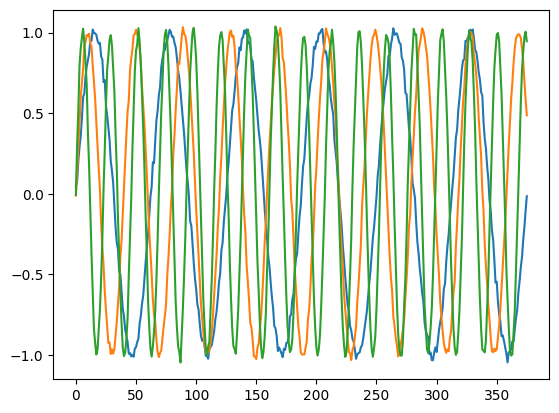

In [382]:
plt.plot(y)

In [383]:
def least_squares(A, B):
    # solve for X in AX = B
    return jnp.linalg.inv(A.T @ A) @ A.T @ B

lambdas = {
    'target': 100,
    'transition': 1000,
    'activation_energy': 1,
    'activation_positivity': 100,
    'readout_energy': 1,
    'transition_energy': 1
}

class CollocationModel(eqx.Module):
    x: jnp.ndarray
    
    def __init__(self, *, D, key):
        keys = iter(jax.random.split(key, 100))
        self.x = jax.random.uniform(next(keys), (T, D), minval=0, maxval=1)
        
    def loss(self, model, y, *, key=None):
        # compute best-fit transition matrix for x(t+1) = W x(t) + b
        x = model.x
        x_1 = jnp.concatenate([x, jnp.ones((T, 1))], axis=1)
        W = least_squares(x_1[:-1], x[1:])
        # compute best-fit readout matrix for y(t) = R x(t) + d
        R = least_squares(x_1, y)
        
        losses = {}
        y_pred = x_1 @ R
        x_next = x_1 @ W
        losses['target'] = einops.reduce((y - y_pred) ** 2, 't d -> ', 'mean')
        losses['transition'] = einops.reduce((x_next[:-1] - x[1:]) ** 2, 't d -> ', 'mean')
        losses['activation_energy'] = einops.reduce(x ** 2, 't d -> ', 'mean')
        losses['activation_positivity'] = einops.reduce((0.5 * (x - jnp.abs(x))) ** 2, 't d -> ', 'mean')
        losses['readout_energy'] = einops.reduce(R ** 2, 'd f -> ', 'mean')
        losses['transition_energy'] = einops.reduce(W ** 2, 'd1 d2 -> ', 'mean')
        
        loss = sum(lambdas[k] * v for k, v in losses.items())
        aux = {
            'losses': losses,
            'y_pred': y_pred,
            'x_next': x_next,
            'W': W,
            'R': R
        }
        return loss, aux
        
@eqx.filter_jit
def train_step(model, optimizer_state, optimizer, y, *, key):
    (_, aux), grad = eqx.filter_value_and_grad(model.loss, has_aux=True)(model, y, key=key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, model)
    model = eqx.apply_updates(model, update)
    return model, optimizer_state, aux


In [384]:
D = 9

key = jax.random.PRNGKey(42)
collocation_model = CollocationModel(D=D, key=key)
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(collocation_model)
for _ in tqdm.trange(int(1e5)):
    key, subkey = jax.random.split(key)
    collocation_model, optimizer_state, collocation_aux = train_step(collocation_model, optimizer_state, optimizer, y, key=subkey)
    if _ % 20000 == 0:
        pprint.pprint(collocation_aux['losses'])

  0%|          | 0/100000 [00:00<?, ?it/s]

{'activation_energy': Array(0.3365612, dtype=float32),
 'activation_positivity': Array(0., dtype=float32),
 'readout_energy': Array(0.01413003, dtype=float32),
 'target': Array(0.4912659, dtype=float32),
 'transition': Array(0.08222036, dtype=float32),
 'transition_energy': Array(0.02768245, dtype=float32)}
{'activation_energy': Array(0.15961055, dtype=float32),
 'activation_positivity': Array(0.00025756, dtype=float32),
 'readout_energy': Array(0.28606826, dtype=float32),
 'target': Array(0.00016662, dtype=float32),
 'transition': Array(6.884027e-05, dtype=float32),
 'transition_energy': Array(0.0829194, dtype=float32)}
{'activation_energy': Array(0.15943782, dtype=float32),
 'activation_positivity': Array(0.00022626, dtype=float32),
 'readout_energy': Array(0.27711332, dtype=float32),
 'target': Array(0.00015589, dtype=float32),
 'transition': Array(7.7815705e-05, dtype=float32),
 'transition_energy': Array(0.08372632, dtype=float32)}
{'activation_energy': Array(0.15984905, dtype=flo

Text(0.5, 0.98, 'collocation activations')

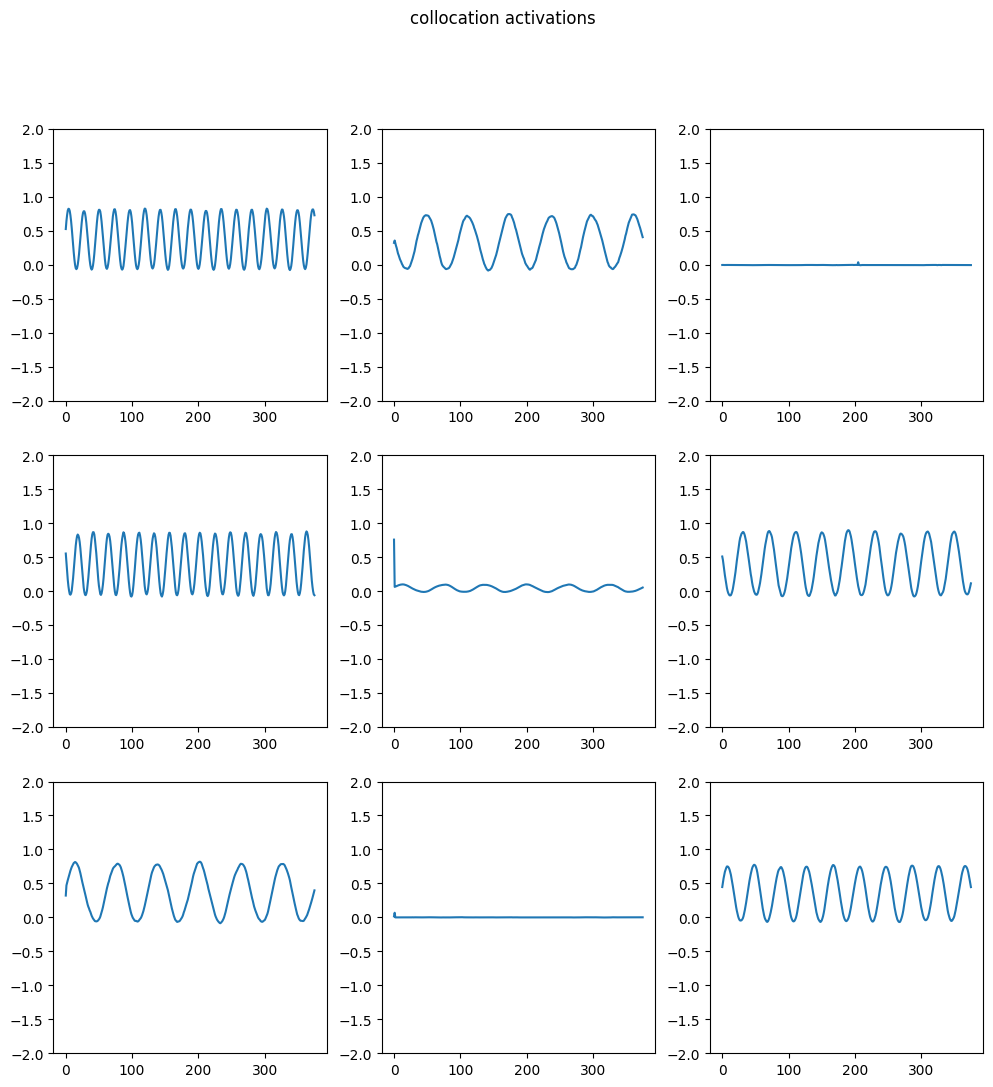

In [385]:
fig, axes = plt.subplots(int(jnp.sqrt(D)), int(jnp.sqrt(D)), figsize=(12, 12))
for i in range(D):
    ax = axes[i // int(jnp.sqrt(D)), i % int(jnp.sqrt(D))]
    ax.plot(collocation_model.x[:, i])
    ax.set_ylim(-2, 2)
fig.suptitle('collocation activations')

Text(0.5, 0.98, 'collocation activations fft')

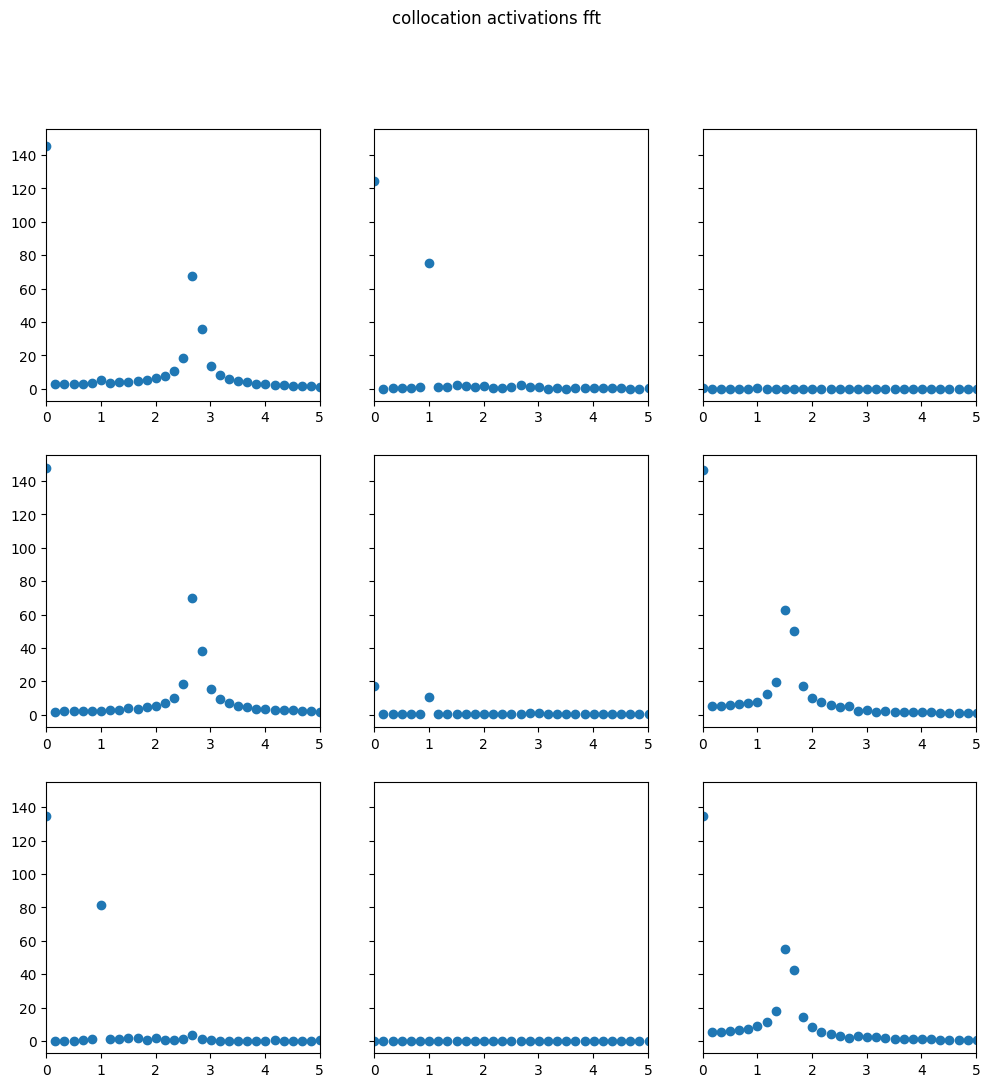

In [386]:
fft_result = jnp.fft.fft(collocation_model.x, axis=0)
frequencies = jnp.fft.fftfreq(fft_result.shape[0], d=SAMPLING_RATE) * 2 * jnp.pi
fig, axes = plt.subplots(int(jnp.sqrt(D)), int(jnp.sqrt(D)), figsize=(12, 12), sharey=True)
for i in range(D):
    ax = axes[i // int(jnp.sqrt(D)), i % int(jnp.sqrt(D))]
    ax.scatter(frequencies, jnp.abs(fft_result[:, i]))
    ax.set_xlim(0, 5)
fig.suptitle('collocation activations fft')

Text(0.5, 1.0, 'y')

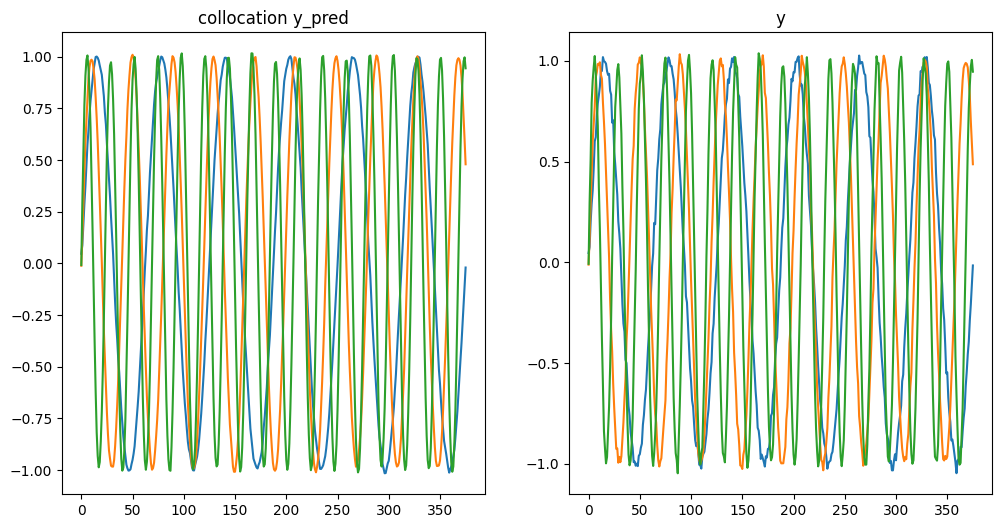

In [387]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(collocation_aux['y_pred'])
axes[0].set_title('collocation y_pred')
axes[1].plot(y)
axes[1].set_title('y')

Text(0.5, 0.98, 'collocation model shooting activations')

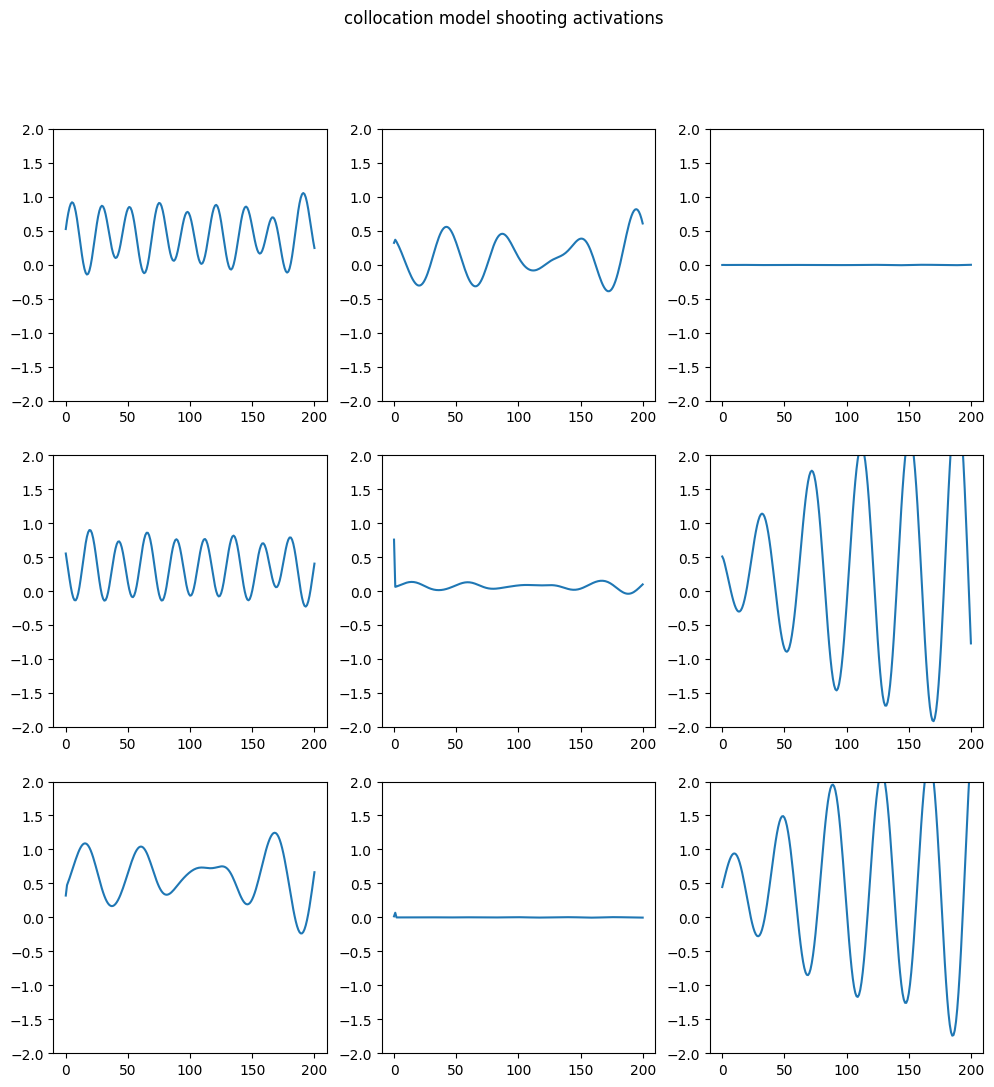

In [388]:
def append_ones(x):
    assert x.ndim == 2
    return jnp.concatenate([x, jnp.ones((x.shape[0], 1))], axis=1)

xs = [collocation_model.x[0:1, :]]
for _ in range(200):
    xs.append(append_ones(xs[-1]) @ collocation_aux['W'])
xs = jnp.concatenate(xs, axis=0)
fig, axes = plt.subplots(int(jnp.sqrt(D)), int(jnp.sqrt(D)), figsize=(12, 12))
for i in range(D):
    ax = axes[i // int(jnp.sqrt(D)), i % int(jnp.sqrt(D))]
    ax.plot(xs[:, i])
    ax.set_ylim(-2, 2)
fig.suptitle('collocation model shooting activations')

Text(0.5, 1.0, 'y')

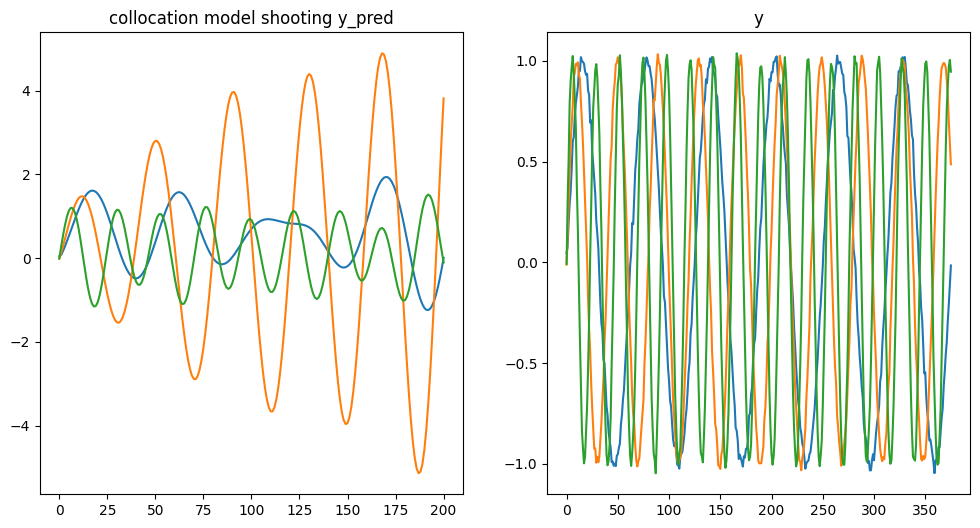

In [389]:
ys = []
for x in xs:
    ys.append(append_ones(einops.rearrange(x, 'D -> () D')) @ collocation_aux['R'])
ys = jnp.concatenate(ys, axis=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(ys)
axes[0].set_title('collocation model shooting y_pred')
axes[1].plot(y)
axes[1].set_title('y')

In [390]:
lambdas = {
    'target': 100,
    'activation_energy': 1,
    'activation_positivity': 100,
    'readout_energy': 1,
    'transition_energy': 1
}

class ShootingModel(eqx.Module):
    x0: jnp.ndarray
    W: jnp.ndarray
    b: jnp.ndarray
    R: jnp.ndarray
    d: jnp.ndarray
    
    def __init__(self, *, x0, W, b, R, d, key):
        keys = iter(jax.random.split(key, 100))
        # self.x0 = jax.random.uniform(next(keys), (D,), minval=0, maxval=1)
        # self.W = jax.random.normal(next(keys), (D, D))
        # self.b = jnp.zeros((D,))
        # self.R = jax.random.normal(next(keys), (D, 2))
        # self.d = jnp.zeros((2,))
        self.x0 = x0
        self.W = W
        self.b = b
        self.R = R
        self.d = d

        
    def loss(self, model, y, *, key=None):
        x0, W, b, R, d = model.x0, model.W, model.b, model.R, model.d
        
        def f(x, dummy):
            x_next = x @ W + b
            return x_next, x_next
        dummy_x = jnp.empty((T - 1, 0))
        xT, xs = jax.lax.scan(f, x0, dummy_x)
        x = jnp.concatenate([x0[None, :], xs], axis=0)
        y_pred = x @ R.T + d
        
        losses = {}
        losses['target'] = einops.reduce((y - y_pred) ** 2, 't d -> ', 'mean')
        losses['activation_energy'] = einops.reduce(x ** 2, 't d -> ', 'mean')
        losses['activation_positivity'] = einops.reduce((0.5 * (x - jnp.abs(x))) ** 2, 't d -> ', 'mean')
        losses['readout_energy'] = einops.reduce(R ** 2, 'd f -> ', 'mean')
        losses['transition_energy'] = einops.reduce(W ** 2, 'd1 d2 -> ', 'mean')
        
        loss = sum(lambdas[k] * v for k, v in losses.items())
        aux = {
            'losses': losses,
            'y_pred': y_pred,
            'x': x,
            'W': W,
            'R': R
        }
        return loss, aux
        


In [399]:
key = jax.random.PRNGKey(43)
shooting_model = ShootingModel(
    x0=collocation_model.x[0, :],
    W=collocation_aux['W'].T[:, :-1],
    b=collocation_aux['W'].T[:, -1],
    R=collocation_aux['R'].T[:, :-1],
    d=collocation_aux['R'].T[:, -1],
    key=key
)
print(shooting_model.x0.shape)
print(shooting_model.W.shape)
print(shooting_model.b.shape)
print(shooting_model.R.shape)
print(shooting_model.d.shape)
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(shooting_model)

for _ in tqdm.trange(100000):
    key, subkey = jax.random.split(key)
    shooting_model, optimizer_state, shooting_aux = train_step(shooting_model, optimizer_state, optimizer, y, key=subkey)
    if _ % 20000 == 0:
        pprint.pprint(shooting_aux['losses'])


(9,)
(9, 9)
(9,)
(3, 9)
(3,)


  0%|          | 0/100000 [00:00<?, ?it/s]

{'activation_energy': Array(247.22427, dtype=float32),
 'activation_positivity': Array(166.75562, dtype=float32),
 'readout_energy': Array(0.31145856, dtype=float32),
 'target': Array(151.09888, dtype=float32),
 'transition_energy': Array(0.08851953, dtype=float32)}
{'activation_energy': Array(0.2655506, dtype=float32),
 'activation_positivity': Array(0.00020457, dtype=float32),
 'readout_energy': Array(0.23982225, dtype=float32),
 'target': Array(0.00134389, dtype=float32),
 'transition_energy': Array(0.09081254, dtype=float32)}
{'activation_energy': Array(0.23241213, dtype=float32),
 'activation_positivity': Array(0.00013198, dtype=float32),
 'readout_energy': Array(0.22822185, dtype=float32),
 'target': Array(0.00068544, dtype=float32),
 'transition_energy': Array(0.08850703, dtype=float32)}
{'activation_energy': Array(0.22525872, dtype=float32),
 'activation_positivity': Array(0.00014441, dtype=float32),
 'readout_energy': Array(0.23210616, dtype=float32),
 'target': Array(0.001622

Text(0.5, 1.0, 'y')

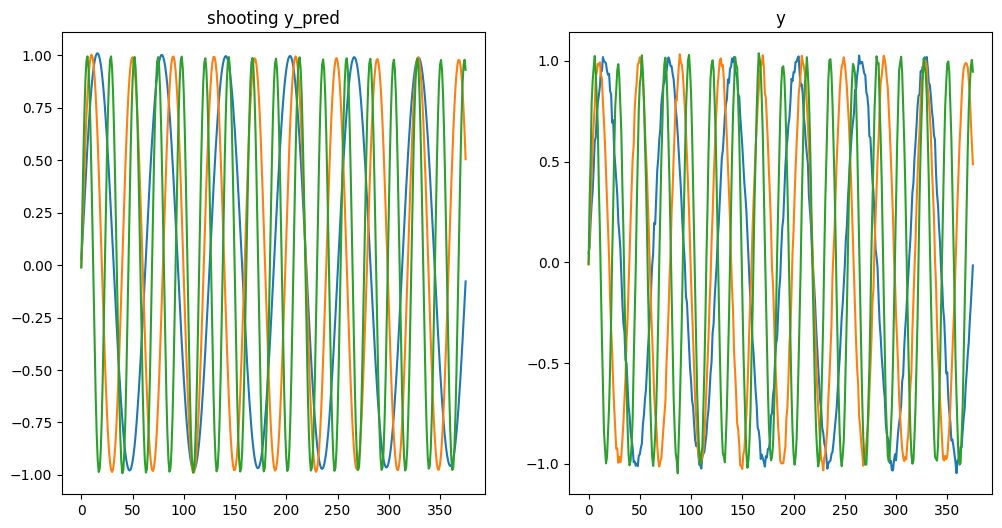

In [400]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(shooting_aux['y_pred'])
axes[0].set_title('shooting y_pred')
axes[1].plot(y)
axes[1].set_title('y')

Text(0.5, 0.98, 'shooting activations')

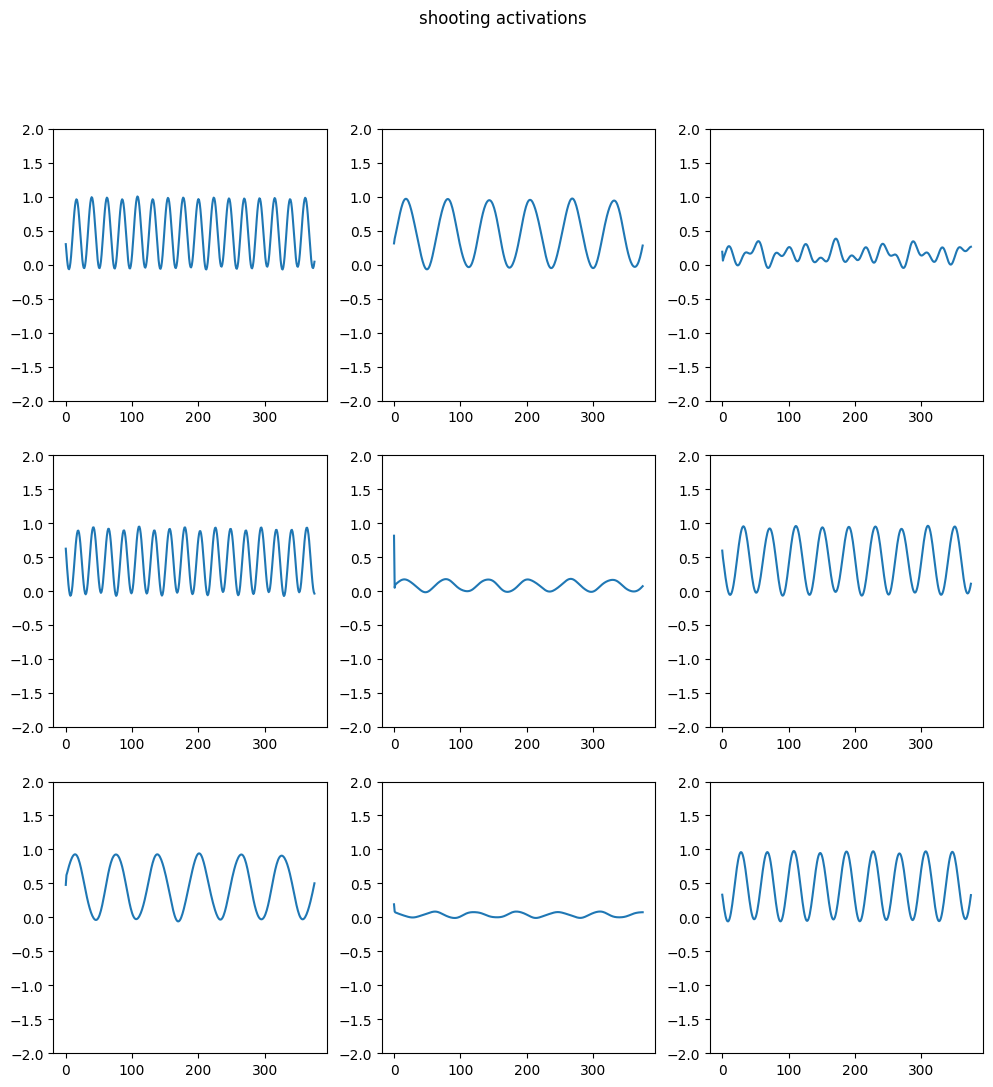

In [401]:
fig, axes = plt.subplots(int(jnp.sqrt(D)), int(jnp.sqrt(D)), figsize=(12, 12))
for i in range(D):
    ax = axes[i // int(jnp.sqrt(D)), i % int(jnp.sqrt(D))]
    ax.plot(shooting_aux['x'][:, i])
    ax.set_ylim(-2, 2)
fig.suptitle('shooting activations')

Text(0.5, 0.98, 'shooting activations fft')

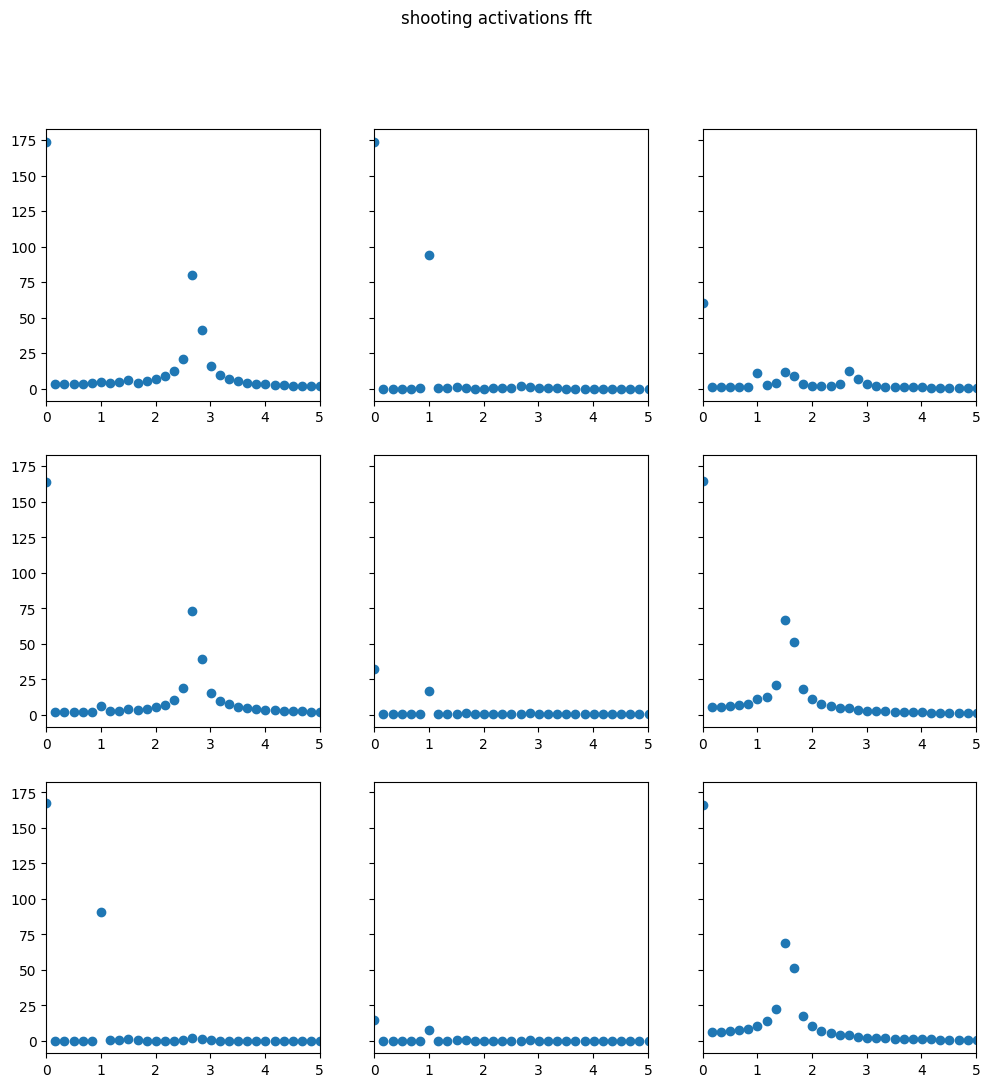

In [402]:
fft_result = jnp.fft.fft(shooting_aux['x'], axis=0)
frequencies = jnp.fft.fftfreq(fft_result.shape[0], d=SAMPLING_RATE) * 2 * jnp.pi
fig, axes = plt.subplots(int(jnp.sqrt(D)), int(jnp.sqrt(D)), figsize=(12, 12), sharey=True)
for i in range(D):
    ax = axes[i // int(jnp.sqrt(D)), i % int(jnp.sqrt(D))]
    ax.scatter(frequencies, jnp.abs(fft_result[:, i]))
    ax.set_xlim(0, 5)
fig.suptitle('shooting activations fft')